# Aligned UMAP reduction of COI

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# %load common_.py
from common import *

In [46]:
import umap
from ehv import core, load as e_load, correlation
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
from sklearn.preprocessing import robust_scale, minmax_scale

In [47]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    pandas.read_csv("data/selected_samples.csv"), "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [48]:
df = df[df["meta_label_coi"]]
df.shape

(293029, 113)

In [49]:
with open("data/selected_features.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [50]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [8]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.1, 0.9))
    return df

# df = df.groupby(["meta_timepoint"]).apply(do_robust_scale)

In [51]:
df = df.drop(columns=correlation.get_correlated_features(df.filter(regex="feat")))

# Define relationships between timepoints

In [52]:
from scipy import spatial
from joblib import Parallel, delayed
from scipy.stats import median_abs_deviation

def get_subsample(vec, target, cols):
    df = target.copy()
    for col in cols:
        delta = median_abs_deviation(df[col])
        df = df[df[col].between(vec[col]-delta, vec[col]+delta)]
        if len(df[col]) == 0:
            return None
    return df

def get_min_index(s, target, dist):
    if target is None:
        return -1
    
    distances = target.apply(lambda row: dist(s, row), axis=1)
    return distances.argmin()

def get_min_distance_relation(source, target, n=10, dist=spatial.distance.cosine, cols=[]):
    result = {}
    index_pool = set(numpy.arange(len(source)))
    while len(result) < n:
        loop_indices = numpy.random.choice(list(index_pool), replace=False, size=n-len(result))
        loop_min_indices = Parallel(n_jobs=24)(delayed(get_min_index)(source.iloc[index], get_subsample(source.iloc[index], target, cols), dist) for index in loop_indices)
        result.update({k:v for k,v in zip(loop_indices, loop_min_indices) if v != -1})
        
        for i in loop_indices:
            index_pool.remove(i) 
        
    return result

In [53]:
df.filter(regex="intensity_mc_ch(04|11)").columns

Index(['feat_intensity_mc_ch04', 'feat_intensity_mc_ch11'], dtype='object')

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_intensity_mc_ch04'>

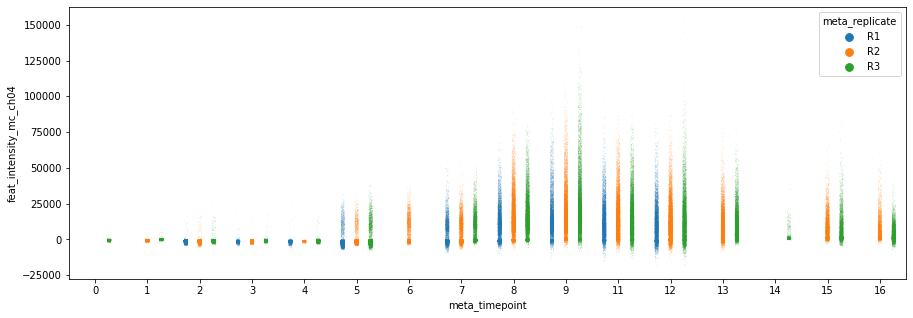

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df, y="feat_intensity_mc_ch04", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_intensity_mc_ch11'>

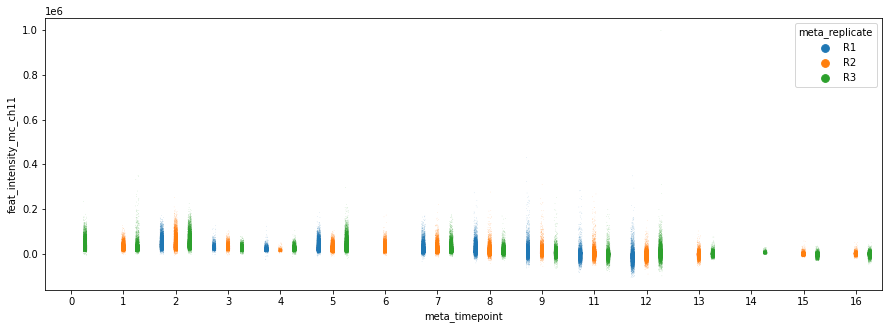

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df, y="feat_intensity_mc_ch11", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_intensity_mc_bf'>

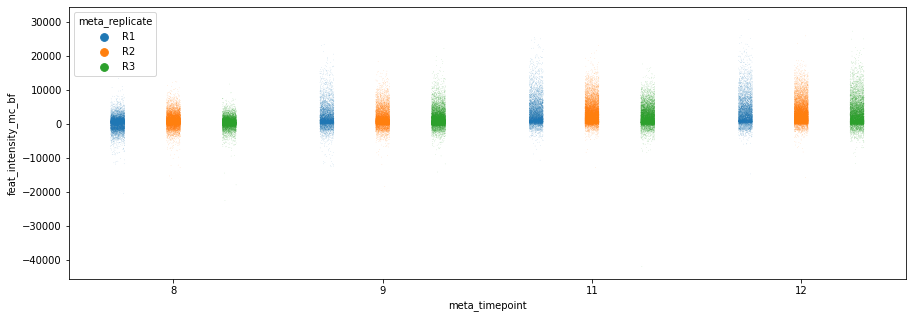

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df, y="feat_intensity_mc_bf", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_intensity_mc_ssc'>

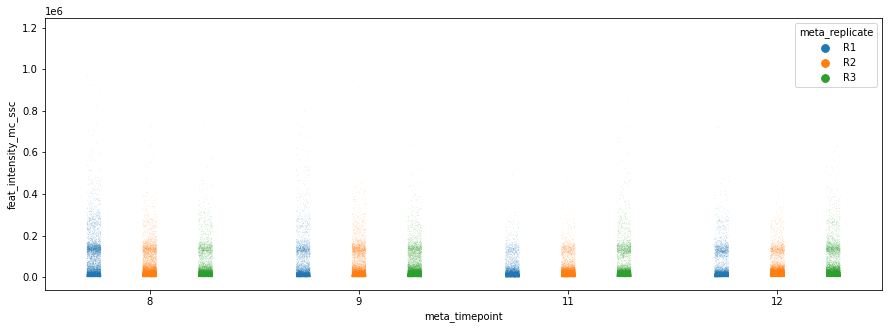

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df, y="feat_intensity_mc_ssc", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

For testing purposes we limit the analysis to timepoints 8 to 12.

In [55]:
df = df[df["meta_timepoint"].between(8, 12, inclusive=True)]

In [56]:
%%time
get_min_distance_relation(
    df[df["meta_timepoint"] == 8].filter(regex="feat"), 
    df[df["meta_timepoint"] == 9].filter(regex="feat"), 
    n=1000, 
    cols=df.filter(regex="intensity_mc_ch(04|11|7)").columns
)

CPU times: user 18.1 s, sys: 1.94 s, total: 20.1 s
Wall time: 29.5 s


{351: 33,
 16436: 2900,
 22441: 192,
 15726: 72,
 17108: 202,
 5615: 110,
 26783: 24,
 21500: 97,
 27572: 94,
 9798: 950,
 21099: 2738,
 24157: 764,
 9600: 1054,
 14606: 85,
 22752: 1221,
 7088: 0,
 22524: 301,
 14773: 397,
 25303: 207,
 19173: 120,
 7243: 1,
 11947: 781,
 15237: 2461,
 13347: 321,
 10985: 73,
 25894: 1777,
 28399: 502,
 15247: 985,
 13747: 395,
 14722: 533,
 24523: 17,
 14396: 635,
 25023: 7,
 14256: 214,
 26019: 247,
 29618: 199,
 16383: 331,
 2754: 31,
 29123: 598,
 27498: 2012,
 14373: 374,
 19380: 969,
 26428: 184,
 27182: 260,
 12161: 705,
 22047: 24,
 12575: 231,
 19373: 1364,
 27745: 94,
 15595: 849,
 8665: 66,
 1280: 30,
 23118: 2317,
 17564: 786,
 27705: 2156,
 24317: 1023,
 26460: 964,
 17367: 2811,
 8350: 66,
 26707: 578,
 15071: 60,
 9826: 889,
 25283: 393,
 6620: 63,
 5561: 11,
 17032: 115,
 16924: 763,
 14452: 32,
 11928: 459,
 8159: 206,
 27266: 1273,
 29739: 288,
 2344: 267,
 26437: 1762,
 2244: 395,
 24693: 142,
 24064: 1856,
 18911: 4,
 2553: 10,
 26

In [58]:
%%time
from tqdm.notebook import tqdm
tps = sorted(df["meta_timepoint"].unique())
relations = []
for i,j in tqdm(zip(tps[0:-1], tps[1:]), total=len(tps)-1):
    relations.append(
        get_min_distance_relation(
            df[df["meta_timepoint"] == i].filter(regex="feat"), 
            df[df["meta_timepoint"] == j].filter(regex="feat"), 
            n=2500,
            cols=df.filter(regex="intensity_mc_ch(04|11|7|bf|ssc)").columns
        ))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 2min 43s, sys: 2.75 s, total: 2min 45s
Wall time: 4min 48s


In [59]:
dump(relations, "data/relations_2500_tp8-12_after_correlation_selection.dat")

['data/relations_2500_tp8-12_after_correlation_selection.dat']

In [60]:
%%time
slices = [v.filter(regex="feat") for _,v in df.groupby("meta_timepoint", sort=True)]
aligned_mapper = umap.AlignedUMAP(metric="cosine").fit(slices, relations=relations)

CPU times: user 11min 34s, sys: 3min 3s, total: 14min 38s
Wall time: 4min 42s


In [61]:
embeddings = []
for embedding in aligned_mapper.embeddings_:
    embeddings.append(embedding)

In [62]:
dump(embeddings, "data/umap/aligned2500_HTR_COI_after_selection_after_correlation_cosine_norobust_scale.dat")

['data/umap/aligned2500_HTR_COI_after_selection_after_correlation_cosine_norobust_scale.dat']

In [71]:
for i,t in enumerate(sorted(df["meta_timepoint"].unique())):
    df.loc[df["meta_timepoint"] == t, "dim_1"] = aligned_mapper.embeddings_[i][:, 0]
    df.loc[df["meta_timepoint"] == t, "dim_2"] = aligned_mapper.embeddings_[i][:, 1]

In [72]:
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

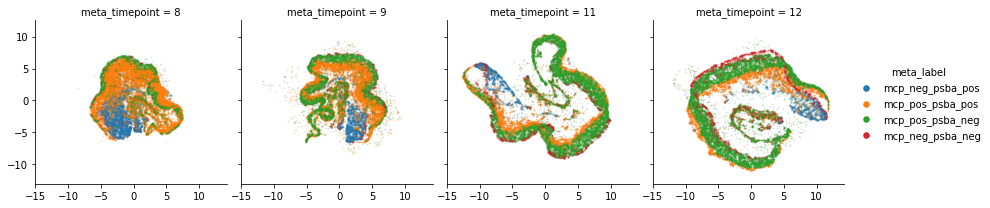

In [78]:
ax_bound = axis_bounds(numpy.vstack(aligned_mapper.embeddings_))

grid = seaborn.FacetGrid(col="meta_timepoint", data=df, hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
grid = grid.map_dataframe(plt.scatter, x="dim_1", y="dim_2", s=0.5, alpha=0.2)
grid.add_legend()

for ax in grid.axes.ravel():
    ax.axis(ax_bound)
for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
plt.savefig("figs/umap/aligned_HTR_Low_COI_tp8-13_after_selection_after_correlatino_cosine.png", dpi=150)

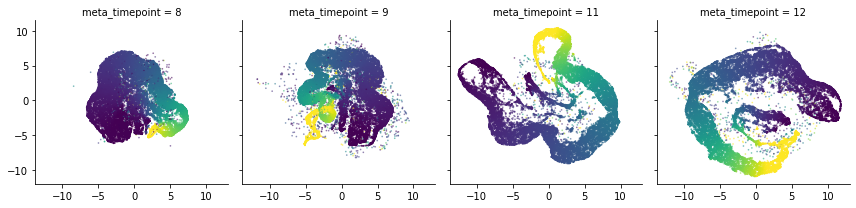

In [80]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_intensity_mc_ch7"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df)
grid = grid.map_dataframe(scatter, x="dim_1", y="dim_2", c=feat, s=0.5, alpha=0.5, cmap="viridis", norm=norm)
    
plt.savefig("figs/umap/aligned_HTR_Low_COI_tp8-13_after_selection_after_correlatino_cosine_intensity_dapi.png")